In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pyannote.core
import numpy as np
from pyannote.core import Annotation
from pyannote.core import Segment
from pyannote.metrics.identification import IdentificationErrorRate
from pyannote.metrics.identification import IdentificationPrecision
from pyannote.metrics.identification import IdentificationRecall
from xarray import DataArray
from munkres import Munkres


### Function to get the path of ground truth 

In [5]:
def getPathToGroundtruth(episode):
    """Return path to groundtruth file for episode"""
    pathToGroundtruth = "../../../tbbt/TBBT/season01/tbbt_season01_annotations/" \
                        + "TheBigBangTheory.Season01.Episode%02d.speakername.ctm" % episode
    return pathToGroundtruth
getPathToGroundtruth(2)

'../../../tbbt/TBBT/season01/tbbt_season01_annotations/TheBigBangTheory.Season01.Episode02.speakername.ctm'

### Function to get the information of  " who speaks when " from ground truth. This is called as reference 

/Users/elancheliyan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


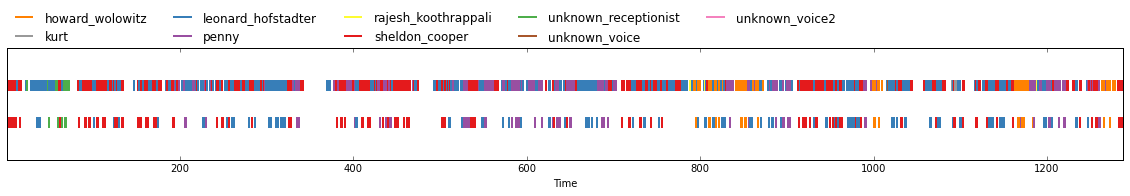

In [6]:
def get_who_speaks_when_reference(episode):
    """Return 'who speaks when' reference as pyannote.core.Annotation"""
    pathToGroundtruth = getPathToGroundtruth(episode)
    with open(pathToGroundtruth, 'r') as fp:
        who_speaks_when = Annotation()
        for line in fp:
            columns = line.strip().split()
            start = float(columns[2])
            end = start + float(columns[3])
            speaker_name = columns[7]
            who_speaks_when[Segment(start, end)] = speaker_name
    return who_speaks_when
get_who_speaks_when_reference(1)

### Function to get the pronounced names from the ground truth. 

/Users/elancheliyan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


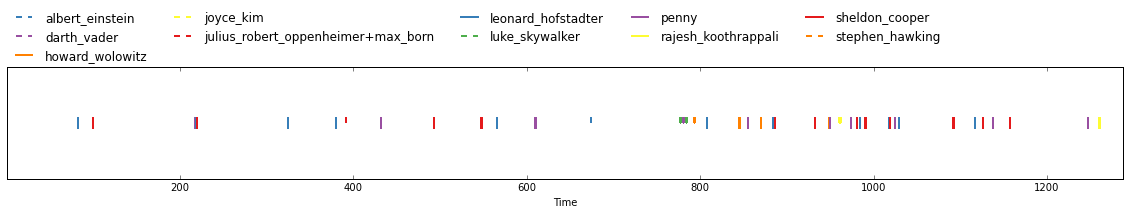

In [7]:
def get_pronounced_names_reference(episode):
    """Return 'pronounced names' reference as pyannote.core.Annotation"""
    
    pathToGroundtruth = getPathToGroundtruth(episode)
    pronounced_names = Annotation()
    with open(pathToGroundtruth, 'r') as fp:
         for line in fp:
            columns = line.strip().split()
            start = float(columns[2])
            end = start + float(columns[3])
            name = columns[9]
            if name != '"':
                pronounced_names[Segment(start, end)]= name
    return pronounced_names
get_pronounced_names_reference(1)

### Function to get the perfect speaker diarization reference from ground truth. 
#### PS: Have to Anonymize the labels in modular code 

/Users/elancheliyan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


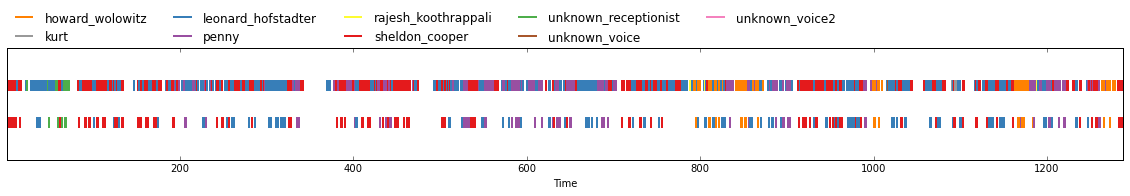

In [8]:
def get_speaker_diarization_reference(episode):
    """Returns 'speaker diarization' reference as pyannote.core.Annotation"""
    who_speaks_when = get_who_speaks_when_reference(episode)
    #speaker_diarization = who_speaks_when.anonymize_labels()
    speaker_diarization = who_speaks_when
    return speaker_diarization
get_speaker_diarization_reference(1)

### Function to the get the co-occurence list . Which is list of list, where each list consists of speaker name and the name pronounced by the speaker . 
#### This function shows the Co_occurence list of all the names. i.e., 1st person, 2nd person and 3rd person names. 

In [9]:
def get_reference_cooccurence_list(episode):
    """Representing speaker and the name by the speaker in the below format 
        [('sheldon_cooper', ['sheldon_cooper']),('howard_wolowitz', ['sheldon_cooper']), ('sheldon_cooper', ['sheldon_cooper']),
         ('howard_wolowitz', []), ('sheldon_cooper', []), ('howard_wolowitz', [])]"""
    pathToGroundtruth = getPathToGroundtruth(episode)
    previous          = ''
    keys=[]
    values =[]
    reference_cooccurence_list=[]
    pronounced_namelist=[]
    speaker_namelist=[]
    with open(pathToGroundtruth, 'r') as fp:
        for line in fp:
            columns = line.strip().split()
            speaker = columns[7]
            name    = columns[9]
            ntype   = columns[10]
            speaker_namelist.append(speaker)
            if previous !=speaker:
                keys.append(speaker)
                values.append(list())
                i=0
            if name != '"':
                pronounced_namelist.append(name)
                values[-1].append(name)
                i+=1
            previous = speaker
        for i,speaker in enumerate(keys):
            reference_cooccurence_list.append((speaker,values[i]))
    return reference_cooccurence_list,speaker_namelist,pronounced_namelist
#get_reference_cooccurence_list(1)       

### Function to get the Co-occurence list. 
 #### This function shows only 1st person, 2nd person names pronounced by the speaker.

In [10]:
def get_1st_and_2nd_person_cooccurence_list(episode):
    """Representing speaker and the pronounced name by the speaker 
        [('sheldon_cooper', ['sheldon_cooper']),('howard_wolowitz', ['sheldon_cooper']), ('sheldon_cooper', ['sheldon_cooper']),
         ('howard_wolowitz', []), ('sheldon_cooper', []), ('howard_wolowitz', [])]"""
    pathToGroundtruth = getPathToGroundtruth(episode)
    previous          = ''
    keys=[]
    values =[]
    get_1st_and_2nd_person_cooccurence=[]
    pronounced_namelist=[]
    speaker_namelist=[]
    with open(pathToGroundtruth, 'r') as fp:
        for line in fp:
            columns = line.strip().split()
            speaker = columns[7]
            name    = columns[9]
            ntype   = columns[10]
            speaker_namelist.append(speaker)
            if previous !=speaker:
                keys.append(speaker)
                values.append(list())
                i=0
            if ntype != '"' and ntype != 'object':
                pronounced_namelist.append(name)
                values[-1].append(name)
                i+=1
            previous = speaker
        for i,speaker in enumerate(keys):
            get_1st_and_2nd_person_cooccurence.append((speaker,values[i]))
    return get_1st_and_2nd_person_cooccurence,speaker_namelist,pronounced_namelist
#get_1st_and_2nd_person_cooccurence_list(11)

### Function which gives the number of times, a pronounced name in current speech turn is a next speaker. 
#### Which is calculated for -5 to +5 neighbourhood

In [11]:
def get_cummlative_graph_for_season(episode):
    newlines=[]
    c=0
    p1=0
    p2=0
    p3=0
    p4=0
    p5=0
    n1=0
    n2=0
    n3=0
    n4=0
    n5=0
    occurencies,_,_ = get_1st_and_2nd_person_cooccurence_list(episode)
    for i, items in enumerate(occurencies):
        for k,j in enumerate(items[1]):
          
            if len(j)>0:
                #check whether the pronounced name is current speaker
                if j==occurencies[i][0]:
                    c=c+1
                # check whether the pronounced name is previous speaker 
                if i!=0 and j==occurencies[i-1][0]:
                    p1=p1+1
                if i!=0 and j==occurencies[i-2][0]:
                    p2=p2+1
                if i!=0 and j==occurencies[i-3][0]:
                    p3=p3+1
                if i!=0 and j==occurencies[i-4][0]:
                    p4=p4+1
                if i!=0 and j==occurencies[i-5][0]:
                    p5=p5+1
                # check whether the pronounced name is next speaker 
                if i+1 < len(occurencies) and j==occurencies[i+1][0]:
                    n1=n1+1
                if i+2 < len(occurencies) and j==occurencies[i+2][0]:
                    n2=n2+1
                if i+3 < len(occurencies) and j==occurencies[i+3][0]:
                    n3=n3+1
                if i+4 < len(occurencies) and j==occurencies[i+4][0]:
                    n4=n4+1
                if i+5 < len(occurencies) and j==occurencies[i+5][0]:
                    n5=n5+1
    newlines.append(str(p5)+ (' ')+str(p4)+ (' ')+str(p3)+ (' ')+str(p2)+ (' ')+str(p1)+ (' ')+ str(c)+ (' ')+str(n1)+ (' ')+str(n2)+ (' ')+str(n3)+ (' ')+str(n4)+ (' ')+str(n5))
    #print(newlines)
    return(newlines)
#for episode in range(1, 18):
#    get_cummlative_graph_for_season(episode)

### Function which creates a reference matrix . In the column side,  we have unique pronounced names and row side we have a unique speaker names.(Anonymized labels)

In [12]:
def create_reference_matrix(episode):
    """Reference matrix using all the pronounced names """
    reference_cooccurence_list, speaker_namelist, pronounced_namelist = get_reference_cooccurence_list(episode)
    unique_speakername = sorted(np.unique(speaker_namelist))
    unique_pronouncedname = sorted(np.unique(pronounced_namelist))
    length_unique_speakername = len(unique_speakername)
    length_unique_pronouncedname = len(unique_pronouncedname)
    z='zzeropad {}'
    if length_unique_speakername < length_unique_pronouncedname:
        r = length_unique_pronouncedname - length_unique_speakername
        length_unique_speakername += r
        unique_speakername.extend([z.format(i) for i in range(r)])
    if length_unique_pronouncedname < length_unique_speakername:
        r = length_unique_speakername - length_unique_pronouncedname
        length_unique_pronouncedname += r
        unique_pronouncedname.extend([z.format(i) for i in range(r)])
    #print(unique_speakername)
    #print(unique_pronouncedname)
    counts = DataArray(np.zeros((length_unique_speakername,length_unique_pronouncedname )), coords=[('speaker', unique_speakername), ('name', unique_pronouncedname)])
    return counts,unique_speakername,unique_pronouncedname,reference_cooccurence_list

#create_reference_matrix(17)

### Function which creates a reference matrix with only 1st and 2nd person pronounced names. In the column side,  we have unique pronounced names and row side we have a unique speaker names.(Anonymized labels)

In [14]:
def create_matrix_1st_and_2nd_person(episode):
    """Reference matrix using the 1st and 2nd person of person name """
    get_1st_and_2nd_person_cooccurence, speaker_namelist, pronounced_namelist = get_1st_and_2nd_person_cooccurence_list(episode)
    unique_speakername = sorted(np.unique(speaker_namelist))
    unique_pronouncedname = sorted(np.unique(pronounced_namelist))
    length_unique_speakername = len(unique_speakername)
    length_unique_pronouncedname = len(unique_pronouncedname)
    z='zzeropad {}'
    if length_unique_speakername < length_unique_pronouncedname:
        r = length_unique_pronouncedname - length_unique_speakername
        length_unique_speakername += r
        unique_speakername.extend([z.format(i) for i in range(r)])
    if length_unique_pronouncedname < length_unique_speakername:
        r = length_unique_speakername - length_unique_pronouncedname
        length_unique_pronouncedname += r
        unique_pronouncedname.extend([z.format(i) for i in range(r)])
    #print(unique_speakername)
    #print(unique_pronouncedname)
    counts = DataArray(np.zeros((length_unique_speakername,length_unique_pronouncedname )), coords=[('speaker', unique_speakername), ('name', unique_pronouncedname)])
    return counts,unique_speakername,unique_pronouncedname,get_1st_and_2nd_person_cooccurence

#create_matrix_1st_and_2nd_person(17)

### Fucntion which propagate the pronounced names to the annonymized speaker based on speaker turns 

/Users/elancheliyan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


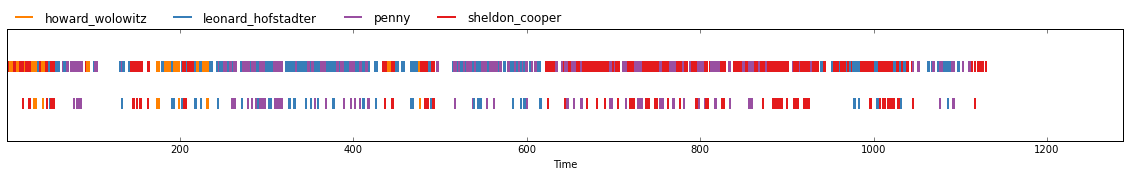

In [15]:
def speech_turn_based_propagation(episode,neighbourhood):
    counts,unique_speakername,unique_pronouncedname,get_1st_and_2nd_person_cooccurence = create_matrix_1st_and_2nd_person(episode)
    cooccurence_list = get_1st_and_2nd_person_cooccurence
    counts=counts
    #print(counts)
    for i, (_, pnames) in enumerate(cooccurence_list):            
        # i is the index of the current speech turn
        # pnames contain all names pronounced in current speech turn
        if i > 0:
            for j in range (1,neighbourhood+1):
                P = cooccurence_list[i-j][0]
                for name in pnames:
                    counts.loc[P,name] += 1
        if i < len(cooccurence_list)-neighbourhood:
            for k in range (1,neighbourhood+1):
                N = cooccurence_list[i+k][0]
                counts.loc[N,pnames] +=1
    #print(counts)
    propagated_names=[]
    all_prop=[]
    cost_matrix = np.max(counts) - counts
    #print(cost_matrix)
    m = Munkres()
    indexes = m.compute(cost_matrix)
    #print(indexes)
    matched_pairs=[]
    for s, n in indexes:
        if s >= len(unique_speakername) or n >= len(unique_pronouncedname):
            continue
        propagated_names.append(unique_pronouncedname[n])
        all_prop.append([unique_speakername[s],unique_pronouncedname[n]])
        who_speaks_when = get_who_speaks_when_reference(episode)
    for (x,y) in all_prop:
        if x==y:
            matched_pairs.append(x)
    who_speaks_when = get_who_speaks_when_reference(episode)
    hypothesis = who_speaks_when.subset(set(matched_pairs))
    return hypothesis
speech_turn_based_propagation(17,5)

### Fucntion which propagate the pronounced names to the annonymized speaker based on time.

/Users/elancheliyan/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


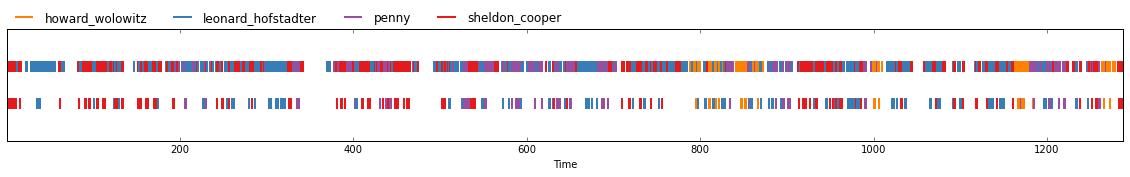

In [16]:
def time_based_propagation(episode,neighbourhood):
    speaker_diarization=get_speaker_diarization_reference(episode)
    pronounced_names= get_pronounced_names_reference(episode)
    Np = len(pronounced_names.labels())
    Ns = len(speaker_diarization.labels())
    #print(Np,Ns)
    name2index = {name: i for i, name in enumerate(pronounced_names.labels())}
    speaker2index = {speaker: i for i, speaker in enumerate(speaker_diarization.labels())}
    N = max(Ns, Np)
    matrix = np.zeros((N, N))
    for name_segment, _, name in pronounced_names.itertracks(label=True):
        name_neighbourhood = Segment(name_segment.start - neighbourhood, name_segment.end + neighbourhood)
        name_index = name2index[name]

        n_neighbourhood = speaker_diarization.crop(name_neighbourhood)
        for speech_turn_segment, _, speaker in n_neighbourhood.itertracks(label=True):
            speaker_index = speaker2index[speaker]
            matrix[speaker_index, name_index] += speech_turn_segment.duration
            cost_matrix = np.max(matrix) - matrix
        m = Munkres()
    indexes = m.compute(cost_matrix)
    allNames = pronounced_names.labels()
    allSpeakers = speaker_diarization.labels()
    all_prop=[]
    matched_pairs=[]
    for s, n in indexes:
        if s >= Ns or n >= Np:
            continue
        all_prop.append([allSpeakers[s],allNames[n]])
    for (x,y) in all_prop:
        if x==y:
            matched_pairs.append(x)
    who_speaks_when =  get_who_speaks_when_reference(episode)
    hypothesis = who_speaks_when.subset(set(matched_pairs))
    return hypothesis
time_based_propagation(1, 20)

### Function which counts the total no of speakers and pronounced name from the ground truth

In [ ]:
def count_of_pronounced_names_and_speaker_names(episode):
    reference_cooccurence_list,speaker_namelist,pronounced_namelist=get_reference_cooccurence_list(episode)
    pronounced_names =get_pronounced_names_reference(episode)
    speaker_names = get_speaker_diarization_reference(episode)
    no_of_unique_pronounced_names = len(np.unique(pronounced_namelist))
    no_of_unique_speaker_name = len(np.unique(speaker_namelist))    
    return no_of_unique_pronounced_names,no_of_unique_speaker_name,pronounced_names.labels(),speaker_names.labels()

count_of_pronounced_names_and_speaker_names(1)

### Function which evaluates the identification error rate :
** Hypothesis  - Results of Speaker turn based method or time based method (Now we worked with ground truth and later here the spech translated text from ASR system)** <br />
**Reference - Reference from the ground truth**

In [17]:
def evaluate(reference, hypothesis):
    """Evaluate hypothesis provided as pyannote.core.Annotation"""
    identificationErrorRate = IdentificationErrorRate()
    return "{0:.3f}".format(identificationErrorRate(reference, hypothesis))
evaluate(get_who_speaks_when_reference(17), speech_turn_based_propagation(17,1))

'0.023'

### Function which calculates precision

In [18]:
from pyannote.metrics.identification import IdentificationPrecision
def identification_precision(reference, hypothesis):
    precision = IdentificationPrecision()
    return "{0:.3f}".format(precision(reference, hypothesis))
    #return precision(reference, hypothesis)
identification_precision(get_who_speaks_when_reference(8), speech_turn_based_propagation(8,1))

'1.000'

### Function which calculates recall 

In [19]:
from pyannote.metrics.identification import IdentificationRecall
def identification_recall(reference, hypothesis):
    recall = IdentificationRecall()
    return "{0:.3f}".format(recall(reference, hypothesis))
    #return recall(reference, hypothesis)
identification_recall(get_who_speaks_when_reference(8), speech_turn_based_propagation(8,1))

'0.798'

### Function which calculates the f_measure 

In [21]:
from pyannote.metrics import f_measure
for neighbourhood in [1,2,3,4,5]:#
    print("For the neighbourhoood ",neighbourhood)
    
    K=[]
    for episode in range(1, 18):
        E=evaluate(get_who_speaks_when_reference(episode), 
                   speech_turn_based_propagation(episode,neighbourhood))
        P=identification_precision(get_who_speaks_when_reference(episode), 
                   speech_turn_based_propagation(episode,neighbourhood))
        R=identification_recall(get_who_speaks_when_reference(episode), speech_turn_based_propagation(episode,neighbourhood))
        F= f_measure(float(P),float(R),1.0)
        K.append(str(E)  + (' ') + str(P) + (' ') + str(R)  + (' ') + str("{0:.3f}".format(F)))
        #print('The episode no:', episode)
        #print()
    ress = '\n'.join(K)
    del K[:]
    with open('IER_neighbourhood_%d.txt' % neighbourhood, 'w') as ctm:
        ctm.writelines(ress)

For the neighbourhoood  1
For the neighbourhoood  2
For the neighbourhoood  3
For the neighbourhoood  4
For the neighbourhoood  5


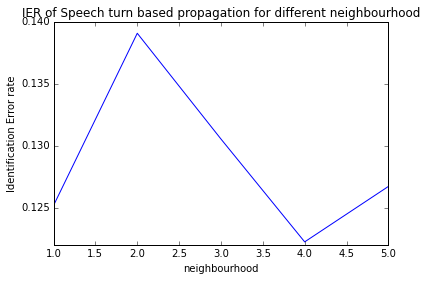

array([ 0.016,  0.001,  0.006,  0.01 ,  0.18 ,  0.125,  0.055,  0.202,
        0.672,  0.007,  0.027,  0.29 ,  0.121,  0.26 ,  0.003,  0.08 ,
        0.023])

In [22]:
from matplotlib import pyplot as plt 
from matplotlib import style
data1 = np.loadtxt("IER_neighbourhood_1.txt",dtype='float')
d11 = data1[:,0]
d12= data1[:,1]
d13= data1[:,2]
d14= data1[:,3]

data2 = np.loadtxt("IER_neighbourhood_2.txt",dtype='float')
d21 = data2[:,0]
d22 = data2[:,1]
d23 = data2[:,2]
d24 = data2[:,3]

data3 = np.loadtxt("IER_neighbourhood_3.txt",dtype='float')
d31 = data3[:,0]
d32 = data3[:,1]
d33 = data3[:,2]
d34 = data3[:,3]

data4 = np.loadtxt("IER_neighbourhood_4.txt",dtype='float')
d41 = data4[:,0]
d42 = data4[:,1]
d43 = data4[:,2]
d44 = data4[:,3]

data5 = np.loadtxt("IER_neighbourhood_5.txt",dtype='float')
d51 = data5[:,0]
d52 = data5[:,1]
d53 = data5[:,2]
d54 = data5[:,3]
x=(1,2,3,4,5)
y = (mean(d11),mean(d21),mean(d31),mean(d41),mean(d51))

plt.plot(x,y)
plt.title('IER of Speech turn based propagation for different neighbourhood')
plt.xlabel('neighbourhood')
plt.ylabel('Identification Error rate')
plt.show()
d41

In [ ]:
# The Optimal neighbour is 4 . The 

In [23]:
from pyannote.metrics import f_measure
from pyannote.metrics.identification import IdentificationRecall
from pyannote.metrics.identification import IdentificationPrecision

for neighbourhood in [5,10,15,20,25,30]:
    print("For the neighbourhoood ",neighbourhood)
    K=[]
    for episode in range(1, 18):
        E=evaluate(get_who_speaks_when_reference(episode), 
                   time_based_propagation(episode,neighbourhood))
        P=identification_precision(get_who_speaks_when_reference(episode), 
                   time_based_propagation(episode,neighbourhood))
        R=identification_recall(get_who_speaks_when_reference(episode), time_based_propagation(episode,neighbourhood))
        F= f_measure(float(P),float(R),1.0)
        K.append(str(E)  + (' ') + str(P) + (' ') + str(R)  + (' ') + str("{0:.3f}".format(F)))
        #print('The episode no:', episode)
        #print()
    ress = '\n'.join(K)
    del K[:]
    with open('Time_based_IER_neighbourhood_%d.txt' % neighbourhood, 'w') as ctm:
        ctm.writelines(ress)

For the neighbourhoood  5
For the neighbourhoood  10
For the neighbourhoood  15
For the neighbourhoood  20
For the neighbourhoood  25
For the neighbourhoood  30


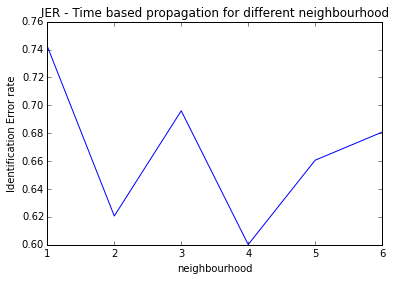

(0.7422352941176471,
 0.62064705882352944,
 0.69605882352941173,
 0.60017647058823531,
 0.66064705882352948,
 0.68076470588235294)

In [26]:
data1 = np.loadtxt("Time_based_IER_neighbourhood_5.txt",dtype='float')
d11 = data1[:,0]
d12= data1[:,1]
d13= data1[:,2]
d14= data1[:,3]

data2 = np.loadtxt("Time_based_IER_neighbourhood_10.txt",dtype='float')
d21 = data2[:,0]
d22 = data2[:,1]
d23 = data2[:,2]
d24 = data2[:,3]

data3 = np.loadtxt("Time_based_IER_neighbourhood_15.txt",dtype='float')
d31 = data3[:,0]
d32 = data3[:,1]
d33 = data3[:,2]
d34 = data3[:,3]

data4 = np.loadtxt("Time_based_IER_neighbourhood_20.txt",dtype='float')
d41 = data4[:,0]
d42 = data4[:,1]
d43 = data4[:,2]
d44 = data4[:,3]

data5 = np.loadtxt("Time_based_IER_neighbourhood_25.txt",dtype='float')
d51 = data5[:,0]
d52 = data5[:,1]
d53 = data5[:,2]
d54 = data5[:,3]

data6 = np.loadtxt("Time_based_IER_neighbourhood_30.txt",dtype='float')
d61 = data6[:,0]
d62 = data6[:,1]
d63 = data6[:,2]
d64 = data6[:,3]
x=(1,2,3,4,5,6)
y = (mean(d11),mean(d21),mean(d31),mean(d41),mean(d51),mean(d61))

plt.plot(x,y)
plt.title('IER - Time based propagation for different neighbourhood')
plt.xlabel('neighbourhood')
plt.ylabel('Identification Error rate')
plt.show()
y